# Analysis of Scenario-Level Heuristic Scores

**Objective:** To load and analyze the aggregated scenario difficulty scores
generated by `score_criticality_scenario.py`. This notebook helps us understand
the overall distribution of scenario difficulty and provides tools to visually
inspect the most critical scenarios to validate our scoring logic.

In [1]:
# ## 1. Setup and Configuration

import os
import sys
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Add project root to path
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.utils.config import load_config
from src.data_processing.validate_parser_output import visualize_scenario

# Load project config and set plot style
config = load_config(config_path='../configs/main_config.yaml')
sns.set_theme(style="whitegrid")

print("Setup Complete.")

Configuration loaded successfully.
Setup Complete.


Loaded scores for 106487 scenarios.

--- Overall Score Statistics ---
count    106487.000000
mean          0.429611
std           0.162337
min           0.025820
25%           0.422801
50%           0.485688
75%           0.513330
max           0.691508
Name: score, dtype: float64


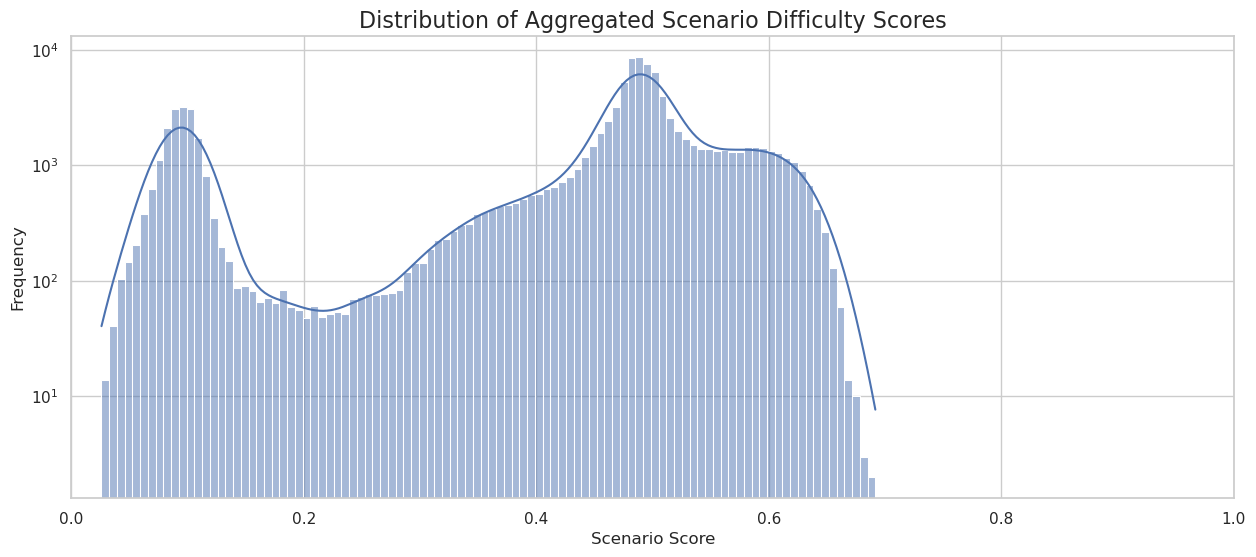


--- Top 10 Most Critical Scenarios ---


,scenario_id,score
2262,15712d3fe994a064.npy,0.691508
83000,dbe89ac10a24d426.npy,0.690758
15690,369a13f0908705a7.npy,0.680821
34104,63fe8e430bfd3b7e.npy,0.678833
8131,23d88ac428af9ad4.npy,0.678343
105578,e6b3a9e1f99d4248.npy,0.677069
66951,b468269706a8a23a.npy,0.676991
105932,f0ab4abb805b3c90.npy,0.676318
55796,98e4008315c4671a.npy,0.676306
18913,3e760c74808a66b4.npy,0.676102


In [3]:
# ## 2. Load Scenario Scores and Analyze Distribution
# 
# Load the final `.pt` file containing the dictionary of `{scenario_id: score}` and analyze its global properties.

# --- Load the Data ---
scores_dir = os.path.join(config['data']['criticality_scores_dir'], 'scenario_level')
heuristic_scores_path = os.path.join(scores_dir, 'heuristic_scenario_scores.pt')

if not os.path.exists(heuristic_scores_path):
    raise FileNotFoundError("Scenario scores not found. Please run `score_criticality_scenario.py` first.")

scenario_scores_dict = torch.load(heuristic_scores_path)

# Convert to a Pandas DataFrame for easy analysis and sorting
scores_df = pd.DataFrame(list(scenario_scores_dict.items()), columns=['scenario_id', 'score'])

print(f"Loaded scores for {len(scores_df)} scenarios.")

# --- Analyze and Plot Distribution ---
print("\n--- Overall Score Statistics ---")
print(scores_df['score'].describe())

plt.figure(figsize=(15, 6))
sns.histplot(scores_df['score'], bins=100, kde=True)
plt.title('Distribution of Aggregated Scenario Difficulty Scores', fontsize=16)
plt.xlabel('Scenario Score')
plt.ylabel('Frequency')
plt.yscale('log') # Use log scale to see the long tail
plt.xlim(0, 1) # Extend x-axis for better visibility
plt.show()

# --- Identify Top Critical Scenarios ---
top_10_critical_scenarios = scores_df.sort_values(by='score', ascending=False).head(10)
print("\n--- Top 10 Most Critical Scenarios ---")
display(top_10_critical_scenarios)

--- Deep Dive Analysis for Top Scenario: 15712d3fe994a064.npy ---
Overall Scenario Score: 0.6915


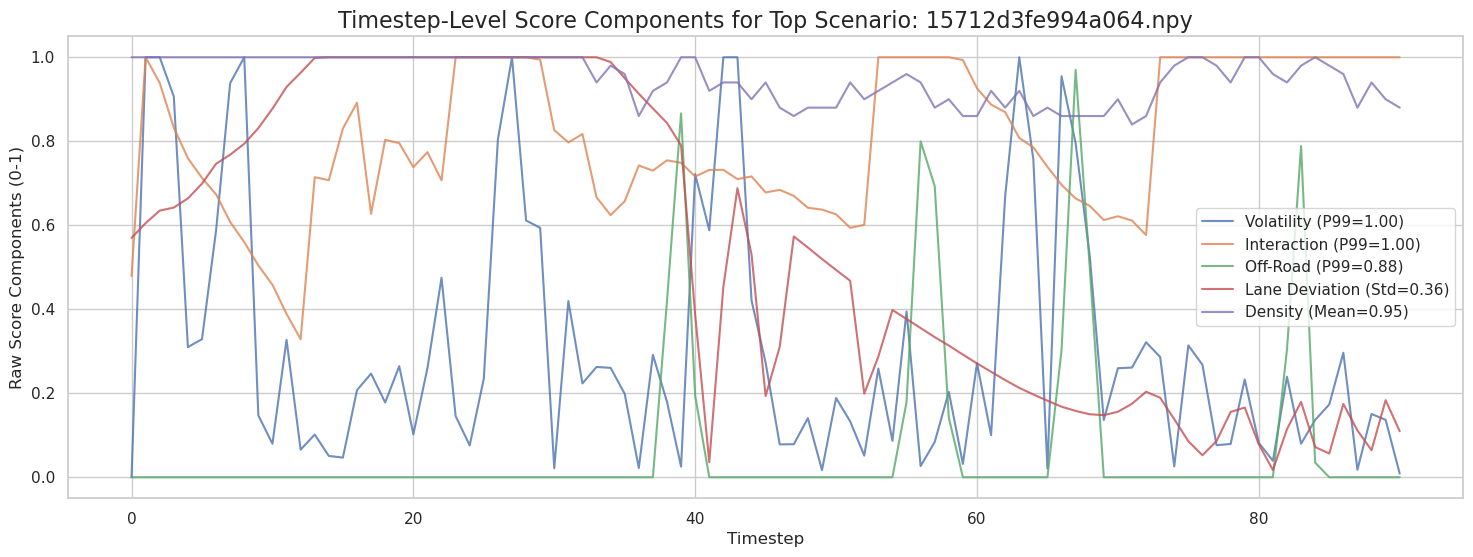

In [6]:
# ## 3. Deep Dive into a Top Critical Scenario
# 
# Let's pick the #1 most critical scenario identified above and visualize its underlying timestep-level scores to understand *why* it received such a high score.

# Select the top scenario
top_scenario_id = top_10_critical_scenarios.iloc[0]['scenario_id']
top_scenario_score = top_10_critical_scenarios.iloc[0]['score']

print(f"--- Deep Dive Analysis for Top Scenario: {top_scenario_id} ---")
print(f"Overall Scenario Score: {top_scenario_score:.4f}")

# --- Load its timestep-level score components ---
timestep_scores_path = os.path.join(
    config['data']['criticality_scores_dir'], 
    'timestep_level', 
    'heuristic', 
    'training', # Assuming it's from the training set, adjust if needed
    f"{top_scenario_id}.npz"
)

if not os.path.exists(timestep_scores_path):
    # Check validation set if not in training
    timestep_scores_path = os.path.join(
        config['data']['criticality_scores_dir'], 
        'timestep_level', 
        'heuristic', 
        'validation',
        f"{top_scenario_id}.npz"
    )
    if not os.path.exists(timestep_scores_path):
        raise FileNotFoundError(f"Could not find timestep scores for {top_scenario_id}")

scores_data = np.load(timestep_scores_path)
volatility = scores_data['volatility']
interaction = scores_data['interaction']
off_road = scores_data['off_road']
density = scores_data['density']
lane_deviation = scores_data['lane_deviation']

# --- Plot the underlying score components ---
fig, ax = plt.subplots(figsize=(18, 6))
timesteps = np.arange(len(volatility))

ax.plot(timesteps, volatility, label=f'Volatility (P99={np.percentile(volatility, 99):.2f})', alpha=0.8)
ax.plot(timesteps, interaction, label=f'Interaction (P99={np.percentile(interaction, 99):.2f})', alpha=0.8)
ax.plot(timesteps, off_road, label=f'Off-Road (P99={np.percentile(off_road, 99):.2f})', alpha=0.8)
ax.plot(timesteps, lane_deviation, label=f'Lane Deviation (Std={np.std(lane_deviation):.2f})', alpha=0.8)
ax.plot(timesteps, density, label=f'Density (Mean={np.mean(density):.2f})', alpha=0.8)

ax.set_title(f'Timestep-Level Score Components for Top Scenario: {top_scenario_id}', fontsize=16)
ax.set_xlabel('Timestep')
ax.set_ylabel('Raw Score Components (0-1)')
ax.legend()
ax.grid(True)
plt.show()

In [13]:
# ## 4. Generate Video for the Top Scenario
# 
# Finally, let's watch the video of this top-ranked scenario to get a full qualitative understanding of why our aggregation method flagged it as highly critical.
top_scenario_id = top_10_critical_scenarios.iloc[2]['scenario_id']

# Remove the .npz extension from the scenario ID
top_scenario_id = top_scenario_id.replace('.npy', '')

raw_data_path = os.path.join(
    config['data']['processed_npz_dir'], 
    'training', # Assuming it's from the training set
    f"{top_scenario_id}.npz"
)
if not os.path.exists(raw_data_path):
    # Check validation set if not in training
    raw_data_path = os.path.join(
        config['data']['processed_npz_dir'], 
        'validation',
        f"{top_scenario_id}.npz"
    )
    if not os.path.exists(raw_data_path):
        raise FileNotFoundError(f"Could not find raw data for {top_scenario_id} on raw_data_path: {raw_data_path}")

print(f"\nGenerating scenario animation for: {top_scenario_id}...")
try:
    video_output_dir = 'outputs/scenario_score_validation_videos'
    visualize_scenario(raw_data_path, output_dir=video_output_dir)
    print(f"\n✅ Animation saved to '{video_output_dir}/{top_scenario_id}.mp4'")
except Exception as e:
    print(f"\n❌ An error occurred during animation: {e}")


Generating scenario animation for: 369a13f0908705a7...
Loading scenario from: /mnt/d/waymo_datasets/waymo_longtail_rl_data/processed_npz/training/369a13f0908705a7.npz
Creating animation for timestep 0 to 90...
Animation saved to: outputs/scenario_score_validation_videos/369a13f0908705a7.mp4

✅ Animation saved to 'outputs/scenario_score_validation_videos/369a13f0908705a7.mp4'
